In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
from bokeh.layouts import row,column,gridplot
from pyspark.sql import SparkSession
from bokeh.models import ColumnDataSource, CategoricalColorMapper, HoverTool,CustomJS,Slider, Panel, Tabs
from matplotlib.ticker import FuncFormatter
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql import functions as F
from bokeh.plotting import figure, output_notebook, show


#tắt những thông báo warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

warnings.filterwarnings("ignore", category=FutureWarning)


<h2>Tạo SparkSession </h2>

In [2]:
# import SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SGU_Student").getOrCreate()


<h2>Đọc file</h2>


In [3]:
#Đọc file csv 
df = spark.read.csv('SGU.csv',header=True)


In [4]:
df.show(5)


+-------------------+----------+--------------------+----------------------------------------------------------------------------+-----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+------------------------+---------------------+--------+
|      Dấu thời gian|      MSSV|           Họ và Tên|Điểm trung bình môn học năm 1 - Hệ 10 (Các bạn lấy trung bình HK1 + HK2 / 2)|Điểm trung bình môn học năm 2 - Hệ 10  (Các bạn lấy trung bình HK1 + HK2 + HK3 / 3)|Khoảng cách từ nhà đến trường (tính bằng Km) - Các bạn có thể mở Google Maps để tính nhanh chóng và chính xác|Thu nhập hằng tháng do làm thêm ngoài giờ học (triệu đồng) - Thông tin này sẽ được đảm bảo bảo mật, các bạn cứ yên tâm|Số anh em trong gia đình|Số bạn thân trong lớp|     Lớp|


In [5]:
df

DataFrame[Dấu thời gian: string, MSSV: string, Họ và Tên: string, Điểm trung bình môn học năm 1 - Hệ 10 (Các bạn lấy trung bình HK1 + HK2 / 2): string, Điểm trung bình môn học năm 2 - Hệ 10  (Các bạn lấy trung bình HK1 + HK2 + HK3 / 3): string, Khoảng cách từ nhà đến trường (tính bằng Km) - Các bạn có thể mở Google Maps để tính nhanh chóng và chính xác: string, Thu nhập hằng tháng do làm thêm ngoài giờ học (triệu đồng) - Thông tin này sẽ được đảm bảo bảo mật, các bạn cứ yên tâm: string, Số anh em trong gia đình: string, Số bạn thân trong lớp: string, Lớp: string]

<h2>Lọc lại dữ liệu </h2>

In [6]:

#Đổi tên cột 
df = df.withColumnRenamed("Điểm trung bình môn học năm 1 - Hệ 10 (Các bạn lấy trung bình HK1 + HK2 / 2)", "ĐTB/Năm1") \
    .withColumnRenamed("Điểm trung bình môn học năm 2 - Hệ 10  (Các bạn lấy trung bình HK1 + HK2 + HK3 / 3)", "ĐTB/Năm2") \
    .withColumnRenamed("Khoảng cách từ nhà đến trường (tính bằng Km) - Các bạn có thể mở Google Maps để tính nhanh chóng và chính xác", "Khoảng cách từ nhà tới trường(km)") \
    .withColumnRenamed("Thu nhập hằng tháng do làm thêm ngoài giờ học (triệu đồng) - Thông tin này sẽ được đảm bảo bảo mật, các bạn cứ yên tâm", "Thu nhập mỗi tháng") \
    .withColumnRenamed("Số anh em trong gia đình", "Số lượng anh em")



#Chỉ lấy các cột này trong bảng 
df = df["MSSV","Họ và Tên","ĐTB/Năm1", "ĐTB/Năm2", "Khoảng cách từ nhà tới trường(km)", "Thu nhập mỗi tháng", "Số lượng anh em", "Số bạn thân trong lớp", "Lớp"]


from pyspark.sql.functions import * 
# filter lại giá trị cho từng cột

df = df.withColumn("ĐTB/Năm1", regexp_replace(col("ĐTB/Năm1"), ",", "."))
df = df.filter(col("ĐTB/Năm1")!='chưa có')
df = df.withColumn("ĐTB/Năm2", regexp_replace(col("ĐTB/Năm2"), ",", "."))
df = df.withColumn("Khoảng cách từ nhà tới trường(km)", regexp_replace(col("Khoảng cách từ nhà tới trường(km)"), "km", ""))\
       .withColumn("Khoảng cách từ nhà tới trường(km)", regexp_replace(col("Khoảng cách từ nhà tới trường(km)"), "KM", ""))
df = df.withColumn("Khoảng cách từ nhà tới trường(km)", regexp_replace(col("Khoảng cách từ nhà tới trường(km)"), ",", "."))
df = df.withColumn("Số lượng anh em", regexp_extract(col("Số lượng anh em"), r'(\d+)', 1))
df = df.withColumn("Thu nhập mỗi tháng", regexp_replace(col("Thu nhập mỗi tháng"), "Null", "0"))
df = df.withColumn("Thu nhập mỗi tháng", regexp_replace(col("Thu nhập mỗi tháng"), "1 chiệu", "1"))
df = df.withColumn("Thu nhập mỗi tháng", regexp_replace(col("Thu nhập mỗi tháng"), ",", "."))
df = df.withColumn("Thu nhập mỗi tháng", when(df["Thu nhập mỗi tháng"] < 100, df["Thu nhập mỗi tháng"] * 100000).otherwise(df["Thu nhập mỗi tháng"]))
df = df.withColumn("Thu nhập mỗi tháng", regexp_replace(col("Thu nhập mỗi tháng"), "\\.", ""))
df = df.withColumn("Thu nhập mỗi tháng", col("Thu nhập mỗi tháng").cast("int"))
df = df.withColumn("Thu nhập mỗi tháng", regexp_replace(col("Thu nhập mỗi tháng"), "\\.", ""))
df = df.withColumn("Lớp", regexp_replace(col("Lớp"), "dct121c3", "DCT121C3"))


# chuyển kiểu dữ liệu 
df_pd = df.toPandas()
df_pd = df_pd.fillna(0)
df_pd['MSSV'] = df_pd['MSSV'].astype(int)
df_pd['Thu nhập mỗi tháng'] = df_pd['Thu nhập mỗi tháng'].astype(float)
df_pd['Họ và Tên'] = df_pd['Họ và Tên'].astype(str)
df_pd['ĐTB/Năm1'] = df_pd['ĐTB/Năm1'].astype(float)
df_pd['ĐTB/Năm2'] = df_pd['ĐTB/Năm2'].astype(float)
df_pd['Khoảng cách từ nhà tới trường(km)'] = df_pd['Khoảng cách từ nhà tới trường(km)'].astype(float)
df_pd['Số lượng anh em'] = df_pd['Số lượng anh em'].astype(int)
df_pd['Số bạn thân trong lớp'] = df_pd['Số bạn thân trong lớp'].astype(int)
df_pd['Lớp'] = df_pd['Lớp'].astype(str)

df_pd

,MSSV,Họ và Tên,ĐTB/Năm1,ĐTB/Năm2,Khoảng cách từ nhà tới trường(km),Thu nhập mỗi tháng,Số lượng anh em,Số bạn thân trong lớp,Lớp
0,3121411149,Nguyễn Ngọc Hạnh Nguyên,6.475,5.180,9.8,0.0,1,3,DCT121C3
1,3121411136,Ngô Nhật Nam,7.600,6.500,14.0,5000000.0,1,4,DCT121C3
2,3121411028,Trần Minh Chiến,7.400,6.200,4.1,1950000.0,1,4,DCT121C3
3,3121411033,Vương Tiểu Cường,8.430,7.990,10.0,0.0,1,15,DCT121C3
4,3121411045,Đặng Nguyễn Quốc Dương,7.350,5.670,7.4,0.0,3,5,DCT121C3
5,3119411077,Nguyễn Công Thọ,7.810,7.620,11.0,3000000.0,0,2,DCT119C1
6,3121411106,Đoàn Minh Khôi,8.350,7.120,7.8,2000000.0,2,5,DCT121C3
7,3121411131,Trần Châu Hải Mi,7.540,6.800,1.6,1500000.0,1,10,DCT121C3
8,3121411184,Huỳnh Phạm Hoàng Sơn,6.200,5.800,20.0,4000000.0,3,10,DCT121C3
9,3121411017,Phan Tuấn Anh,7.605,7.185,16.0,1000000.0,2,4,DCT121C3


In [7]:
df = df.withColumn("Lớp", regexp_replace(col("Lớp"), "dct121c3", "DCT121C3"))


In [8]:
print(df_pd.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   MSSV                               28 non-null     int64  
 1   Họ và Tên                          28 non-null     object 
 2   ĐTB/Năm1                           28 non-null     float64
 3   ĐTB/Năm2                           28 non-null     float64
 4   Khoảng cách từ nhà tới trường(km)  28 non-null     float64
 5   Thu nhập mỗi tháng                 28 non-null     float64
 6   Số lượng anh em                    28 non-null     int64  
 7   Số bạn thân trong lớp              28 non-null     int64  
 8   Lớp                                28 non-null     object 
dtypes: float64(4), int64(3), object(2)
memory usage: 2.1+ KB
None


<h2>Thống kê cột ĐTB/Năm1 và ĐTB/Năm2</h2>

In [9]:
# Lấy mô tả thống kê cho hai cột 'ĐTB/Năm1' và 'ĐTB/Năm2'
description = df_pd[['ĐTB/Năm1', 'ĐTB/Năm2']].describe().loc[['mean', 'min', 'std', '25%', '50%', '75%', 'max']]

# In mô tả thống kê
description


,ĐTB/Năm1,ĐTB/Năm2
mean,7.077321,6.235536
min,2.550000,2.620000
std,1.254302,1.117892
25%,6.516250,5.775000
50%,7.470000,6.235000
75%,7.802500,6.880000
max,8.440000,7.990000


- mean (trung bình): Đây là giá trị trung bình của dữ liệu, tức là tổng của tất cả các giá trị chia cho số lượng các giá trị. Trong trường hợp này, mean của 'ĐTB/Năm1' là 7.077321 và của 'ĐTB/Năm2' là 6.235536.
- min (giá trị nhỏ nhất): Đây là giá trị nhỏ nhất trong tập dữ liệu, tức là giá trị mà không có giá trị nào nhỏ hơn. 'ĐTB/Năm1' có giá trị nhỏ nhất là 2.550000 và 'ĐTB/Năm2' là 2.620000.
- std (độ lệch chuẩn): Đây là một độ đo cho biết mức độ phân tán của dữ liệu từ giá trị trung bình. Nó cho biết độ lệch của các giá trị so với giá trị trung bình. Trong trường hợp này, std của 'ĐTB/Năm1' là 1.254302 và của 'ĐTB/Năm2' là 1.117892.
- 25%, 50%, 75% (phần trăm phân vị): Đây là các phân vị của dữ liệu, tức là giá trị mà một phần trăm dữ liệu nhỏ hơn (25%, 50% là median, 75% là giá trị mà 75% dữ liệu nhỏ hơn). Chẳng hạn, 25% của 'ĐTB/Năm1' là 6.516250, median (50%) là 7.470000, và 75% là 7.802500.
- max (giá trị lớn nhất): Đây là giá trị lớn nhất trong tập dữ liệu, tức là giá trị mà không có giá trị nào lớn hơn. 'ĐTB/Năm1' có giá trị lớn nhất là 8.440000 và 'ĐTB/Năm2' là 7.990000.

In [10]:
df_pd.head(5)

,MSSV,Họ và Tên,ĐTB/Năm1,ĐTB/Năm2,Khoảng cách từ nhà tới trường(km),Thu nhập mỗi tháng,Số lượng anh em,Số bạn thân trong lớp,Lớp
0,3121411149,Nguyễn Ngọc Hạnh Nguyên,6.475,5.18,9.8,0.0,1,3,DCT121C3
1,3121411136,Ngô Nhật Nam,7.600,6.50,14.0,5000000.0,1,4,DCT121C3
2,3121411028,Trần Minh Chiến,7.400,6.20,4.1,1950000.0,1,4,DCT121C3
3,3121411033,Vương Tiểu Cường,8.430,7.99,10.0,0.0,1,15,DCT121C3
4,3121411045,Đặng Nguyễn Quốc Dương,7.350,5.67,7.4,0.0,3,5,DCT121C3


In [11]:
df_pd.tail()

,MSSV,Họ và Tên,ĐTB/Năm1,ĐTB/Năm2,Khoảng cách từ nhà tới trường(km),Thu nhập mỗi tháng,Số lượng anh em,Số bạn thân trong lớp,Lớp
23,3121411052,Nhâm Minh Đạt,2.550,2.620,21.0,400000.0,2,10,DCT121C3
24,3121411171,Vũ Bình Phước,6.435,5.100,2.0,1000000.0,3,10,DCT121C3
25,3121411226,Trần Quang Vinh,5.500,6.500,8.0,3000000.0,2,1,DCT121C3
26,3121411060,Nguyễn Trí Đức,8.400,6.200,6.0,500000.0,2,15,DCT121C3
27,3121411056,Đặng Ngân Đông,6.750,6.175,18.0,0.0,2,2,DCT121C1


<h2> Sự chênh lệch của ĐTB/Năm1 và ĐTB/Năm2 </h2>

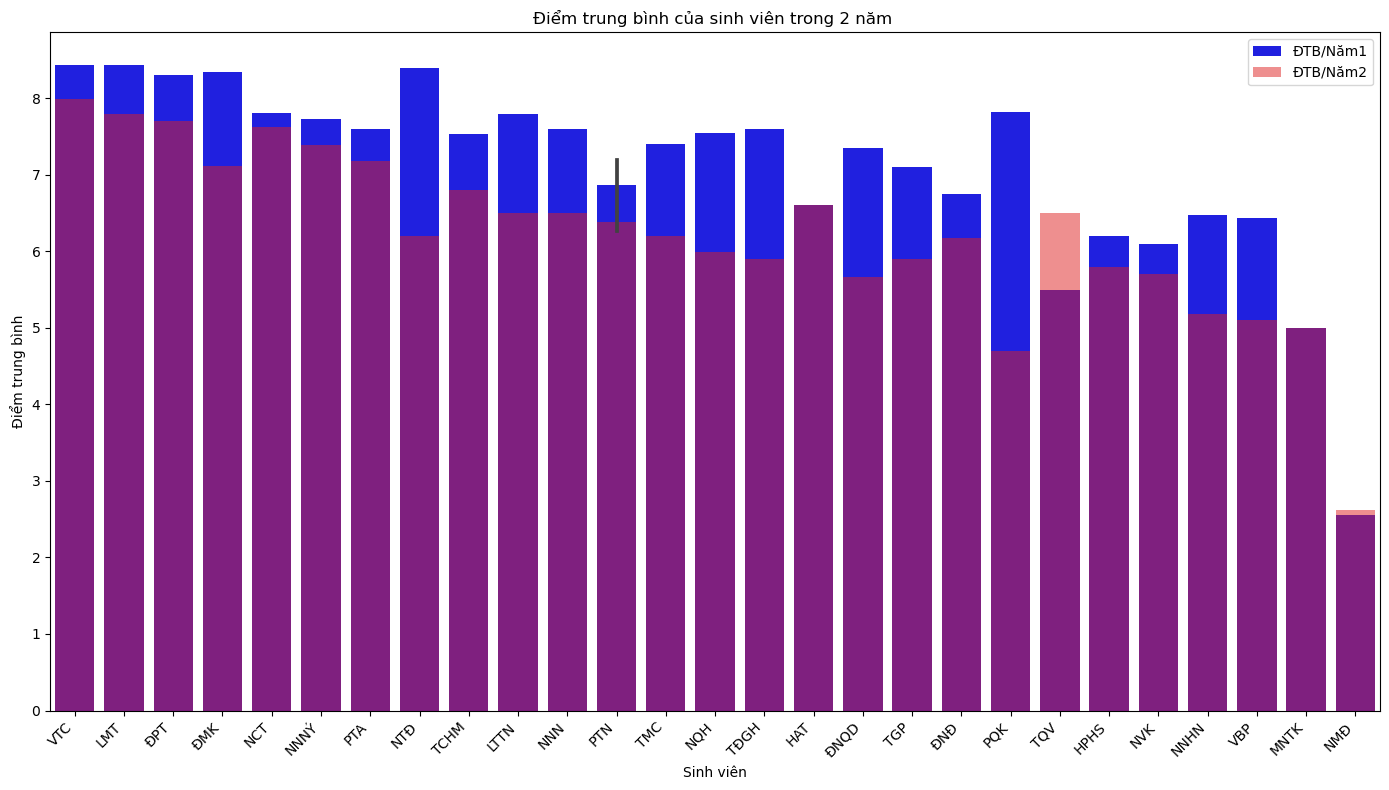

In [12]:

# Tạo cột mới chứa điểm trung bình
df_pd['ĐTB_TrungBinh'] = (df_pd['ĐTB/Năm1'] + df_pd['ĐTB/Năm2']) / 2

# Sắp xếp lại DataFrame theo điểm trung bình
df_sorted = df_pd.sort_values(by='ĐTB_TrungBinh', ascending=False)

# Tạo cột mới chứa tên viết tắt của sinh viên
Ten_Viet_Tat = df_sorted['Họ và Tên'].apply(lambda x: ''.join([word[0] for word in x.split()]))

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
sns.barplot(x=Ten_Viet_Tat, y='ĐTB/Năm1', data=df_sorted, color='blue', label='ĐTB/Năm1')
sns.barplot(x=Ten_Viet_Tat, y='ĐTB/Năm2', data=df_sorted, color='red', label='ĐTB/Năm2', alpha=0.5)
plt.title("Điểm trung bình của sinh viên trong 2 năm ")
plt.xlabel("Sinh viên")
plt.ylabel("Điểm trung bình")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Xóa cột mới
df_pd.drop(columns=['ĐTB_TrungBinh'], inplace=True)


Trong biểu đồ này, chúng ta thấy rằng đa số các sinh viên có điểm trung bình của năm học đầu tiên (ĐTB/Năm1) cao hơn so với năm học thứ hai (ĐTB/Năm2). Chỉ có hai sinh viên có điểm trung bình của năm học thứ hai cao hơn so với năm học đầu tiên. Điều này cho thấy một xu hướng chung là điểm số của học sinh trong lớp thường cao hơn ở năm học đầu tiên so với năm học sau.

Một điểm đáng chú ý khác là sinh viên VTC có điểm trung bình cao nhất trong lớp cho cả hai năm học.


<h2>Phân loại của sinh viên trong lớp</h2>

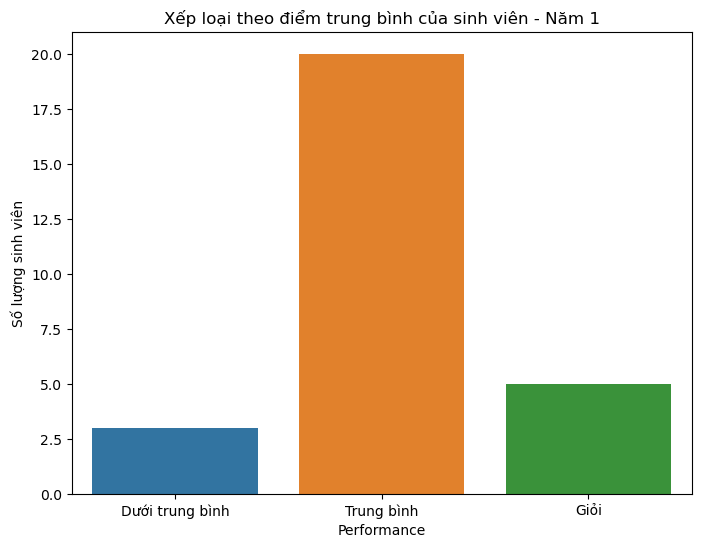

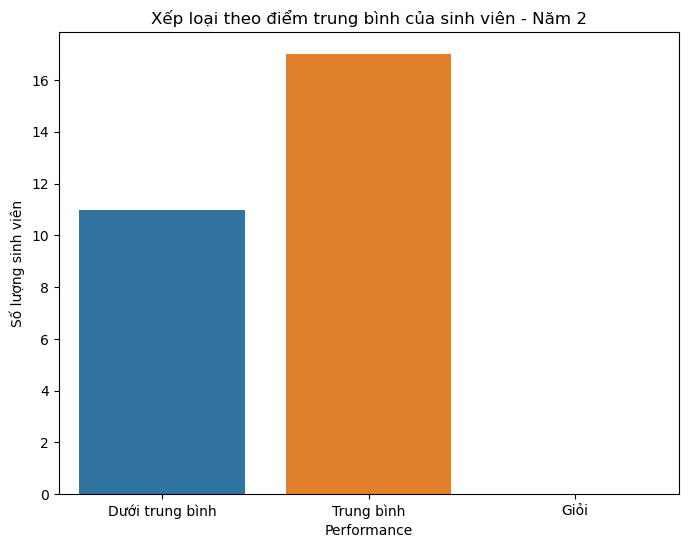

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo cột nhãn dựa trên điểm trung bình
def label_performance(score):
    if score > 8:
        return "Giỏi"
    elif score > 6:
        return "Trung bình"
    else:
        return "Dưới trung bình"

# Tạo cột nhãn cho năm 1 và năm 2
df_pd['Loại/Năm1'] = df_pd['ĐTB/Năm1'].apply(label_performance)
df_pd['Loại/Năm2'] = df_pd['ĐTB/Năm2'].apply(label_performance)

# Vẽ countplot cho cột nhãn Performance cho năm 1
plt.figure(figsize=(8, 6))
sns.countplot(x='Loại/Năm1', data=df_pd, order=['Dưới trung bình', 'Trung bình', 'Giỏi'])
plt.title("Xếp loại theo điểm trung bình của sinh viên - Năm 1")
plt.xlabel("Performance")
plt.ylabel("Số lượng sinh viên")
plt.show()

# Vẽ countplot cho cột nhãn Performance cho năm 2
plt.figure(figsize=(8, 6))
sns.countplot(x='Loại/Năm2', data=df_pd, order=['Dưới trung bình', 'Trung bình', 'Giỏi'])
plt.title("Xếp loại theo điểm trung bình của sinh viên - Năm 2")
plt.xlabel("Performance")
plt.ylabel("Số lượng sinh viên")
plt.show()


Trong phân phối xếp loại cho hai năm học của sinh viên trong lớp, chúng ta nhận thấy rằng đa số các bạn tập trung ở mức xếp loại Trung bình, có nghĩa là điểm trung bình của họ nằm trong khoảng từ 6 đến dưới 8. Điều này cho thấy rằng phần lớn sinh viên đều đạt được kết quả học tập tương đối ổn định, nhưng không đạt được mức điểm cao nhất.

Một điểm đáng chú ý là biểu đồ cũng cho thấy sự thay đổi trong phân phối xếp loại giữa hai năm học. Trong khi loại Giỏi không còn xuất hiện ở năm thứ hai, thì loại Dưới trung bình lại tăng lên đáng kể từ 3 sinh viên lên đến 11 sinh viên. Điều này có thể chỉ ra một sự suy giảm trong hiệu suất học tập của một số sinh viên, có thể do nhiều yếu tố như sự thay đổi trong môi trường học tập, áp lực học tập, hoặc sự thay đổi trong cách tiếp cận học tập.

In [14]:
count_gt_1 = df.filter((col("ĐTB/Năm2") - col("ĐTB/Năm1")) > 0.5).count()
count_lt_minus_1 = df.filter((col("ĐTB/Năm2") - col("ĐTB/Năm1")) < -1).count()
count_between_minus_1_and_1 = df.filter((col("ĐTB/Năm2") - col("ĐTB/Năm1")).between(-1, 0.4)).count()

print("Số sinh viên có ĐTB giữa năm 1 và năm 2 tăng:", count_gt_1)
print("Số sinh viên có ĐTB giữa năm 1 và năm 2 giảm:", count_lt_minus_1)
print("Số sinh viên có ĐTB giữa năm 1 và năm 2 tăng giảm không đáng kể:", count_between_minus_1_and_1)


Số sinh viên có ĐTB giữa năm 1 và năm 2 tăng: 1
Số sinh viên có ĐTB giữa năm 1 và năm 2 giảm: 12
Số sinh viên có ĐTB giữa năm 1 và năm 2 tăng giảm không đáng kể: 15


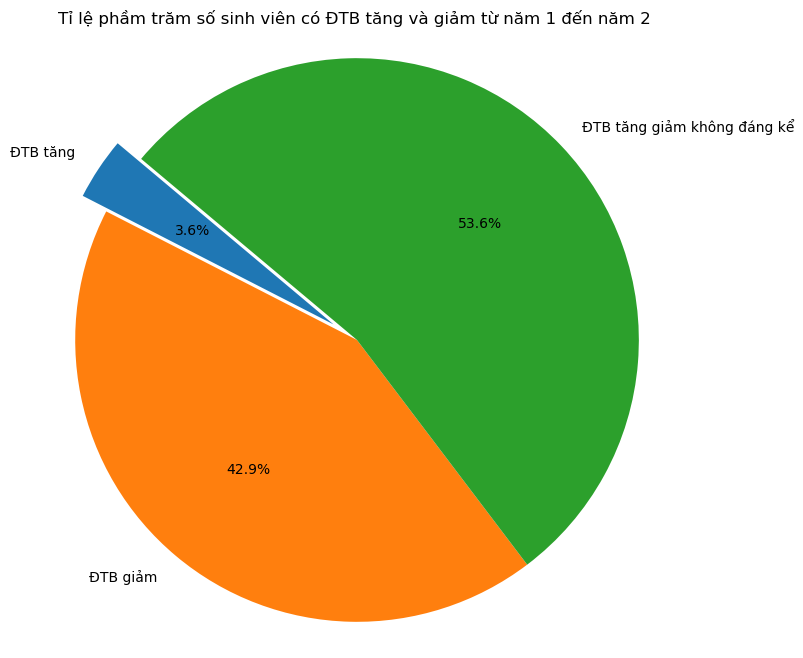

In [15]:
#pie plot
import matplotlib.pyplot as plt

# Dữ liệu đã được tính toán từ trước
counts = [count_gt_1, count_lt_minus_1, count_between_minus_1_and_1]
labels = ['ĐTB tăng', 'ĐTB giảm', 'ĐTB tăng giảm không đáng kể']
explode = (0.1, 0, 0)  # Tách các phần tử đầu tiên ra

# Tạo biểu đồ pie plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.title('Tỉ lệ phầm trăm số sinh viên có ĐTB tăng và giảm từ năm 1 đến năm 2 ')
plt.show()


Biêu đồ cho thấy :
   - ĐTB năm 1 tăng so với năm 2 chiếm : 3.6%
   - ĐTB tăng không đáng kể nằm trong khoảng -1 đến 0.4 chiếm :53.6%
   - ĐTB giảm chiếm : 42.9%

In [16]:
count_duoi_5_n1 = df.filter(df["ĐTB/Năm1"] < 5).count()

# Đếm số sinh viên có ĐTB/năm1 từ 5 đến dưới 7
count_tu_5_den_7_n1 = df.filter((df["ĐTB/Năm1"] >= 5) & (df["ĐTB/Năm1"] < 7)).count()

# Đếm số sinh viên có ĐTB/năm1 trên 7
count_tren_7_n1 = df.filter(df["ĐTB/Năm1"] > 7).count()


In [17]:
count_duoi_5_n2 = df.filter(df["ĐTB/Năm2"] < 5).count()

# Đếm số sinh viên có ĐTB/năm1 từ 5 đến dưới 7
count_tu_5_den_7_n2 = df.filter((df["ĐTB/Năm2"] >= 5) & (df["ĐTB/Năm2"] < 7)).count()

# Đếm số sinh viên có ĐTB/năm1 trên 7
count_tren_7_n2 = df.filter(df["ĐTB/Năm2"] > 7).count()

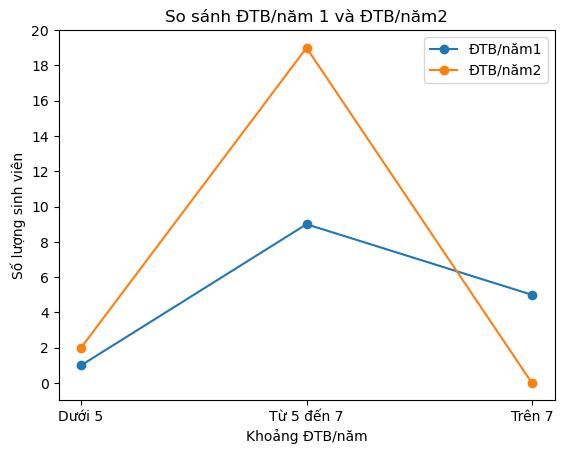

In [18]:
#LINE PLOT
import matplotlib.pyplot as plt


labels_1 = ['Dưới 5', 'Từ 5 đến 7', 'Trên 7']
counts_1 = [count_duoi_5_n1, count_tu_5_den_7_n1, count_tren_7_n1]

labels_2 = ['Dưới 5', 'Từ 5 đến 7', 'Trên 7']
counts_2 = [count_duoi_5_n2, count_tu_5_den_7_n2, count_tren_7_n2]

# Vẽ biểu đồ line plot
plt.plot(labels_1, counts_1, marker='o', linestyle='-', label='ĐTB/năm1')
plt.plot(labels_2, counts_2, marker='o', linestyle='-', label='ĐTB/năm2')

# Đặt tiêu đề và nhãn cho các trục
plt.title('So sánh ĐTB/năm 1 và ĐTB/năm2')
plt.xlabel('Khoảng ĐTB/năm')
plt.ylabel('Số lượng sinh viên')
plt.yticks(range(0,21,2))

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


Biểu đồ cho thấy được 2 giá trị Điểm trung bình của năm 1 và năm 2 có sự khác biệt:
   - ở ĐTB/Nawm1 thì từ 5 đến 7 khá it tuy nhiên vẫn có vài bạn trên 7 và chỉ có 1 bạn dưới 5
   - ở ĐTB/Nawm2 thì ở khoảng 5 đến 7 có nhiều bạn hơn nhiều so với năm nhất, tuy nhiên không có ai trên 7 và lại có thêm 1 bạn dưới 5

<h2> Phân bố Điểm Trung Bình của lớp</h2>

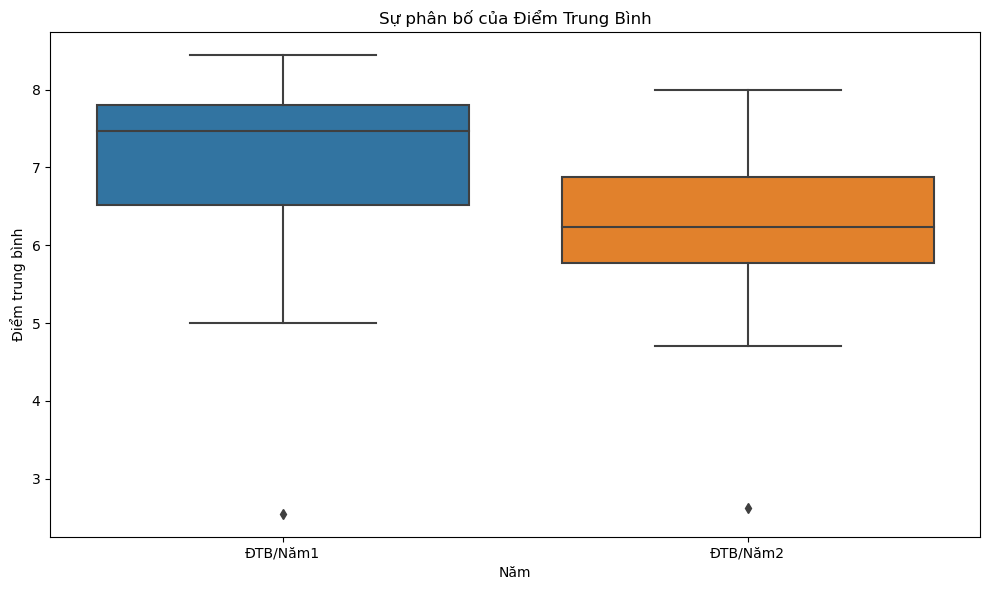

In [19]:
# Vẽ biểu đồ boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pd[['ĐTB/Năm1', 'ĐTB/Năm2']])
plt.title("Sự phân bố của Điểm Trung Bình")
plt.xlabel("Năm")
plt.ylabel("Điểm trung bình")
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


Tứ phân vị là các giá trị trong tập dữ liệu chia thành bốn phần bằng nhau, mỗi phần chiếm 25% tổng số quan sát. Q1 (25%) là giá trị trung bình cộng của dãy số nửa dưới của hộp (box), Q2 (50%) là giá trị trung bình cộng của hộp, và Q3 (75%) là giá trị trung bình cộng của dãy số nửa trên của hộp.

Outliers là những giá trị thiểu số trong tập dữ liệu, nằm rất xa so với các giá trị phổ biến, có thể là quá cao hoặc quá thấp so với phân phối chung của dữ liệu.

IQR  là phạm vi giữa Q1 và Q3, được sử dụng để hình thành ra hộp. Nó biểu thị sự biến động của dữ liệu trong một phần trung tâm của phân phối và là một đo lường thường được sử dụng để xác định outliers. Minimum và maximum trong boxplot thường được tính bằng Q1 trừ đi 1.5 lần IQR và Q3 cộng với 1.5 lần IQR tương ứng.







Trong box của 'ĐTB/Năm1', chúng ta thấy rằng:

- Tứ phân vị Q1 nằm ở khoảng 6.5 điểm, đại diện cho mức điểm dưới trung bình của phân phối.
- Tứ phân vị Q2, đại diện cho median, nằm trong khoảng giá trị trung bình xấp xỉ 7.4 điểm.
- Tứ phân vị thứ 3 (Q3) nằm trong khoảng gần 8 điểm, chỉ ra rằng có một phần nhỏ các sinh viên có điểm cao hơn trong nhóm này.
- Max của box nằm trên 8 điểm, chỉ ra rằng có một số sinh viên có điểm rất cao trong năm đầu tiên.
- Min là 5 điểm, chỉ ra điểm thấp nhất trong tập dữ liệu.
- Có một outlier nằm gần 2 điểm, biểu thị cho một giá trị rất thấp và không phù hợp với phân phối chung của dữ liệu.

Trong box của 'ĐTB/Năm2', chúng ta cũng quan sát được:


- Tứ phân vị Q1 nằm ở khoảng 5.7 điểm, cho thấy một phần lớn sinh viên có điểm thấp hơn so với năm đầu tiên.
- Median (Q2) nằm trong khoảng 6.2 điểm, chỉ ra điểm trung bình của nhóm.
- Tứ phân vị thứ 3 (Q3) nằm gần 6.8 điểm, cho thấy một phần nhỏ sinh viên có điểm cao hơn.
- Max của box nằm gần 8 điểm, biểu thị cho một số sinh viên có điểm cao trong năm thứ hai.
- Min dưới 4.9 điểm, là điểm thấp nhất trong tập dữ liệu.
- Có một outlier nằm gần 2 điểm, cho thấy một giá trị rất thấp và không phù hợp với phân phối chung của dữ liệu.

Có sự thay đổi đáng kể giữa điểm trung bình của sinh viên giữa hai năm học. Trong khi điểm trung bình của 'ĐTB/Năm1' tập trung cao hơn và có phạm vi rộng hơn, điểm trung bình của 'ĐTB/Năm2' thường thấp hơn và có phạm vi hẹp hơn. Điều này có thể cho thấy một xu hướng giảm điểm trung bình từ năm đầu tiên đến năm thứ hai.

<h2>Thu nhập ảnh hưởng đến điểm trung bình </h2>

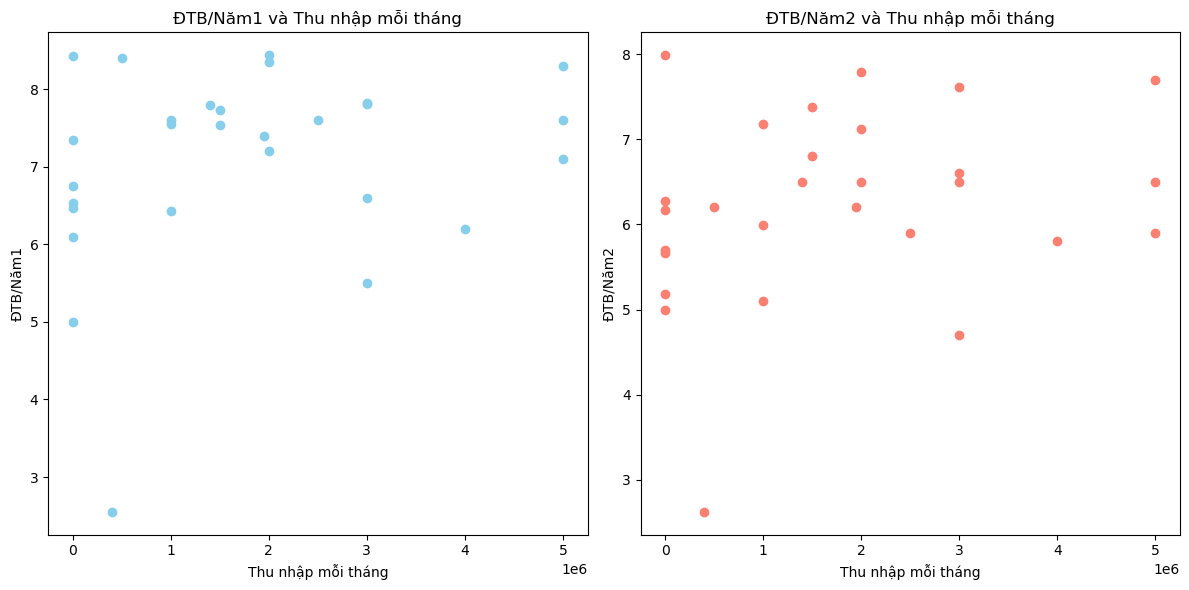

In [20]:
import matplotlib.pyplot as plt

# Dữ liệu từ DataFrame
diem_tb_nam1 = df_pd['ĐTB/Năm1']
diem_tb_nam2 = df_pd['ĐTB/Năm2']
thu_nhap_moi_thang = df_pd['Thu nhập mỗi tháng']

# Tạo figure và axes cho hai biểu đồ
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ scatter plot cho ĐTB/Năm1 và thu nhập mỗi tháng
axs[0].scatter(thu_nhap_moi_thang, diem_tb_nam1, color='skyblue')
axs[0].set_title('ĐTB/Năm1 và Thu nhập mỗi tháng')
axs[0].set_xlabel('Thu nhập mỗi tháng')
axs[0].set_ylabel('ĐTB/Năm1')

# Biểu đồ scatter plot cho ĐTB/Năm2 và thu nhập mỗi tháng
axs[1].scatter(thu_nhap_moi_thang, diem_tb_nam2, color='salmon')
axs[1].set_title('ĐTB/Năm2 và Thu nhập mỗi tháng')
axs[1].set_xlabel('Thu nhập mỗi tháng')
axs[1].set_ylabel('ĐTB/Năm2')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


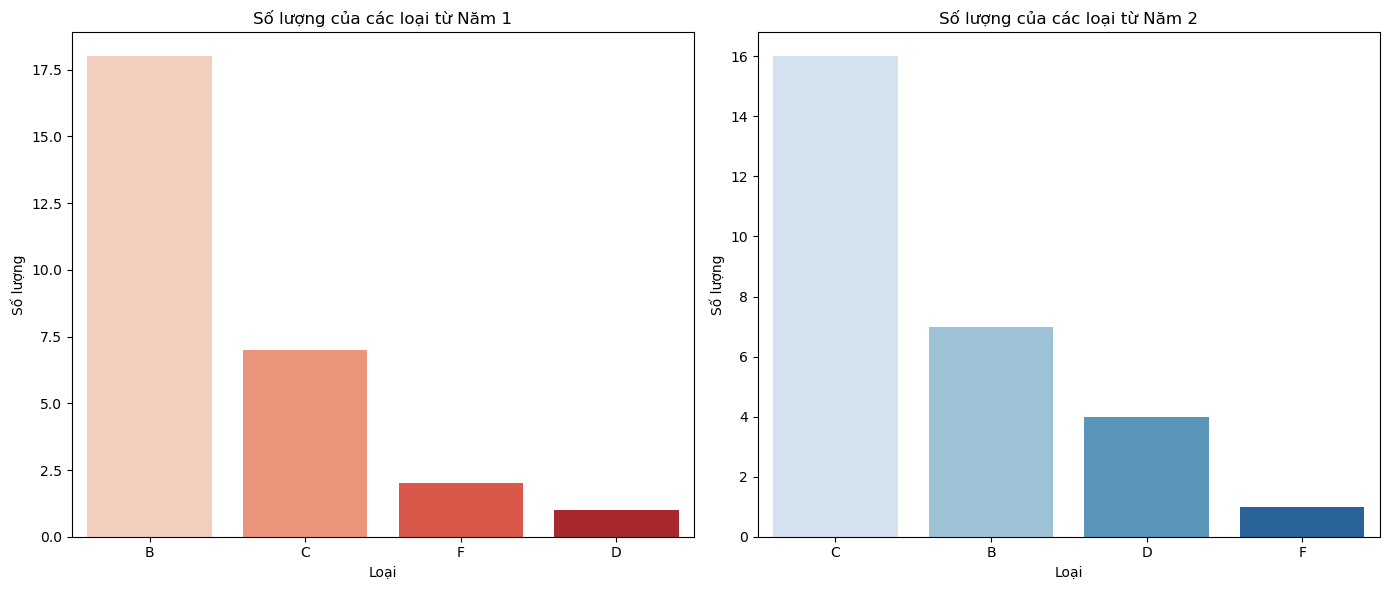

In [21]:
def label_performance(score):
    if score > 8.5 : 
        return "A"
    elif score <8.5 and score > 7:
        return "B"
    elif score <7 and score >5.5:
        return "C"
    elif score <5.5 and score > 4:
        return "D"
    else :
        return "F"

# Áp dụng hàm đánh nhãn hiệu suất vào cột ĐTB/Năm1 và ĐTB/Năm2
df_pd['Loại/Năm1'] = df_pd['ĐTB/Năm1'].apply(label_performance)
df_pd['Loại/Năm2'] = df_pd['ĐTB/Năm2'].apply(label_performance)

# Tạo subplot
plt.figure(figsize=(14, 6))

# Subplot cho năm 1
plt.subplot(1, 2, 1)
sns.countplot(x=df_pd['Loại/Năm1'],order=df_pd['Loại/Năm1'].value_counts().index, palette='Reds')
plt.xlabel('Loại')
plt.ylabel('Số lượng')
plt.title('Số lượng của các loại từ Năm 1')

# Subplot cho năm 2
plt.subplot(1, 2, 2)
sns.countplot(x=df_pd['Loại/Năm2'],order=df_pd['Loại/Năm2'].value_counts().index, palette='Blues')
plt.xlabel('Loại')
plt.ylabel('Số lượng')
plt.title('Số lượng của các loại từ Năm 2')

plt.tight_layout()
plt.show()


<h2>Linear Regression(Hồi quy tuyến tính) </h2>

$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n + \varepsilon $

In [22]:
from sklearn.linear_model import LinearRegression

# Chọn các biến độc lập và biến phụ thuộc
X = df_pd[['Khoảng cách từ nhà tới trường(km)']]
y = df_pd['ĐTB/Năm1']

model = LinearRegression()

# Fit mô hình vào dữ liệu
model.fit(X, y)

# In ra các hệ số hồi quy và hệ số chặn
print('Hệ số hồi quy:', model.coef_)
print('Hệ số chặn:', model.intercept_)


Hệ số hồi quy: [-0.04336368]
Hệ số chặn: 7.637332411982222


  - Hệ số hồi quy:  -0.04336368.Trong trường hợp này,với mỗi đơn vị tăng trong khoảng cách từ nhà tới trường, điểm trung bình của sinh viên trong năm học sẽ giảm đi khoảng 0.04336368 điểm.
 - Hệ số chặn : 7.637332411982222.Trong trường hợp này, có thể hiểu là khi khoảng cách từ nhà tới trường là 0 (tức là sinh viên sống ngay gần trường), điểm trung bình của sinh viên trong năm học sẽ có giá trị gần bằng 7.64.

<h2>Sự ảnh hưởng tới ĐTB/Năm1 của khoảng cách từ nhà tới trường</h2>

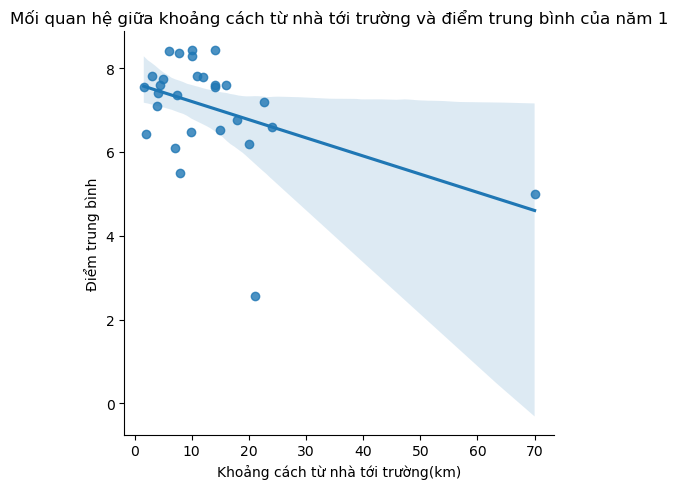

In [23]:
# Vẽ lmplot
sns.lmplot(x='Khoảng cách từ nhà tới trường(km)', y='ĐTB/Năm1', data=df_pd)

# Đặt tiêu đề và nhãn trục
plt.title("Mối quan hệ giữa khoảng cách từ nhà tới trường và điểm trung bình của năm 1")
plt.xlabel("Khoảng cách từ nhà tới trường(km)")
plt.ylabel("Điểm trung bình")

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Biểu đồ này cho thấy đường hồi quy đang theo chiều xuống, điều này có nghĩa là khi giá trị độc lập (Khoảng các từ nhà tới trường(km)) tăng, thì Điểm Trung Bình sẽ có xu hướng giảm và cụ thể là 0.04336368
và khoảng tin cậy hẹp chứng tỏ là ở đó có độ tin cậy cao và độ chính xác cao. 

<h2>Độ chênh lệch của Số bạn thân trong lớp</h2>

Để tính toán skewness của số bạn thân trong lớp, chúng ta cần tính mean (𝜇), standard deviation (σ), và sau đó sử dụng công thức skewness
<h3>Tính mean($\mu$)
$
\mu = \frac{\sum_{i=1}^{n} x_i}{n}
$,
Tính standard deviation($\sigma$)
$
\sigma = \sqrt{\frac{\sum_{i=1}^{n} (x_i - \mu)^2}{n}}
$
</h3>

<h3>
Sau khi có mean và standard deviation rồi thế vào công thức :
    $\text{Skewness} = \frac{\sum_{i=1}^{n} (x_i - \mu)^3 / n}{\sigma^3}$
</h3>


In [24]:
from scipy.stats import skew
skewness = skew(df_pd['Số bạn thân trong lớp'], bias=False)

print("skewness của Số bạn thân trong lớp", skewness)

skewness của Số bạn thân trong lớp 1.8369043250320987


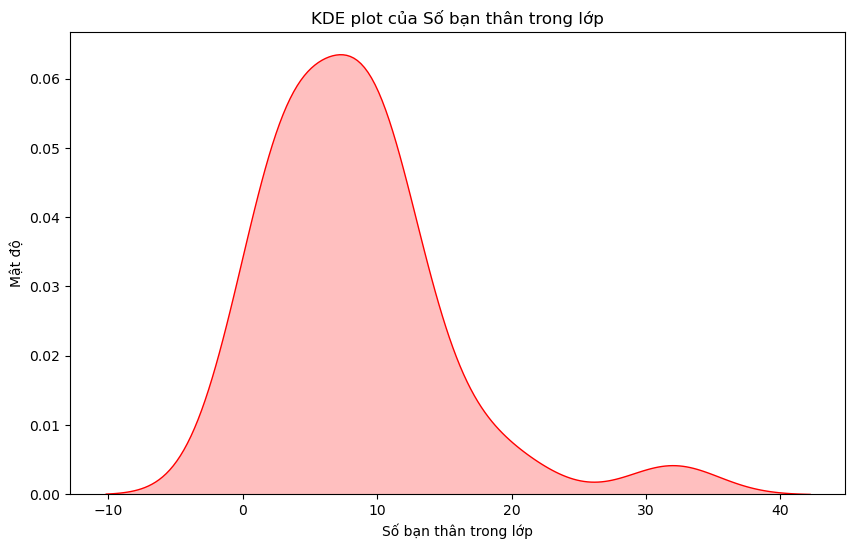

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_pd['Số bạn thân trong lớp'], color='red', shade=True)
plt.title('KDE plot của Số bạn thân trong lớp')
plt.xlabel('Số bạn thân trong lớp')
plt.ylabel('Mật độ')
plt.show()

Biểu đồ cho thấy rằng hầu hết các quan sát về phân bố tập trung ở bên trái của giá trị trung bình, trong trường hợp này là khoảng 10 số bạn thân trong lớp. Tuy nhiên, cũng có một số ít cá nhân có số lượng bạn thân lớn hơn và nhỏ 10.

<h2>Hệ số biến thiên của ĐTB/Năm1</h2>

$ CV = \frac{\text{Độ lệch chuẩn}}{\text{Giá trị trung bình}} \times 100 $

In [26]:
# Tính hệ số biến thiên của cột 'ĐTB/Năm1'
CV = df_pd['ĐTB/Năm1'].std() / df_pd['ĐTB/Năm1'].mean() * 100

print("Hệ số biến thiên của cột 'ĐTB/Năm1': {:.2f}%".format(CV))


Hệ số biến thiên của cột 'ĐTB/Năm1': 17.72%


Hệ số biến thiên thể hiện tỷ lệ phần trăm của độ biến động tương đối của dữ liệu so với giá trị trung bình của cột 'ĐTB/Năm1'. Trong trường hợp này, giá trị của CV là 17.72%, có nghĩa là độ biến động của 'ĐTB/Năm1' chiếm khoảng 17.72% so với giá trị trung bình của 'ĐTB/Năm1'.



<h2>Phân phối điểm trung bình của 2 học kì </h2>

In [27]:

df_pd['ĐTB_TrungBinh'] = (df_pd['ĐTB/Năm1'] + df_pd['ĐTB/Năm2']) / 2

# Tính mean (trung bình)
mean = np.mean(df_pd['ĐTB_TrungBinh'])

# Tính median (trung vị)
median = np.median(df_pd['ĐTB_TrungBinh'])

# Tính mode (trị số xuất hiện nhiều nhất)
mode = stats.mode(df_pd['ĐTB_TrungBinh'])

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)


Mean: 6.656428571428572
Median: 6.76
Mode: ModeResult(mode=array([6.]), count=array([2]))


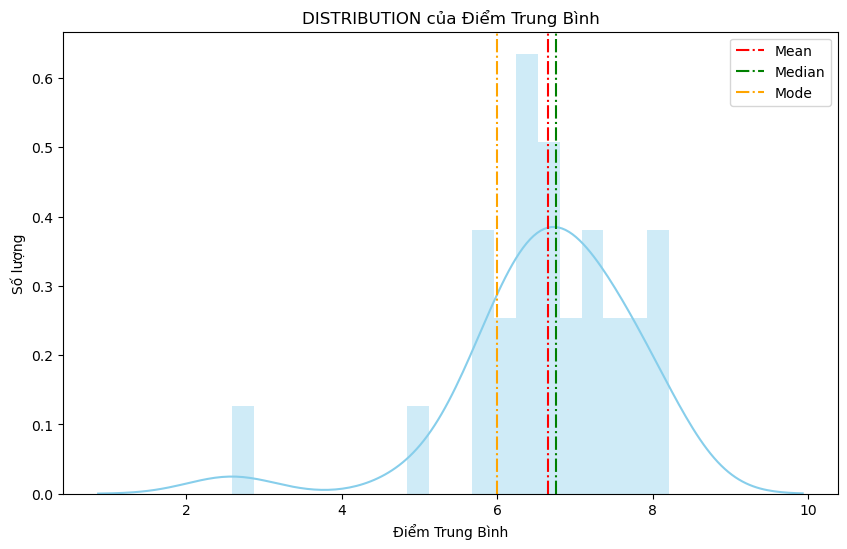

In [28]:

# Tạo histogram
plt.figure(figsize=(10, 6))
sns.distplot(df_pd['ĐTB_TrungBinh'], bins=20, kde=True, color='skyblue')

# Vẽ đường phân phối trung bình
plt.axvline(x=mean, color='red', linestyle='-.', label='Mean')
plt.axvline(x=median, color='green', linestyle='-.', label='Median')
plt.axvline(x=mode.mode[0], color='orange', linestyle='-.', label='Mode')

# Thêm chú thích và tiêu đề
plt.legend()
plt.xlabel('Điểm Trung Bình')
plt.ylabel('Số lượng')
plt.title('DISTRIBUTION của Điểm Trung Bình')

# Hiển thị biểu đồ
plt.show()
df_pd.drop(columns=['ĐTB_TrungBinh'], inplace=True)


Mode : Mode là giá trị xuất hiện nhiều nhất trong dữ liệu. Trong trường hợp này, mode được xác định là 6, tức là 6 là giá trị xuất hiện nhiều nhất trong tập dữ liệu.

Mean (trung bình): Là tổng của tất cả các giá trị trong dữ liệu chia cho số lượng các giá trị. Mean được tính là khoảng 6.7.

Median (trung vị): Là giá trị ở vị trí giữa của dãy số đã được sắp xếp theo thứ tự tăng dần. Trong trường hợp này, median được xác định là khoảng 6.6.

Trong trường hợp phân phối dữ liệu không đối xứng, mean thường bị ảnh hưởng bởi các giá trị outliers


<h2> Sự tương quan giữa các biến </h2>

Text(0.5, 1.0, 'Sự tương quan giữa các giá trị')

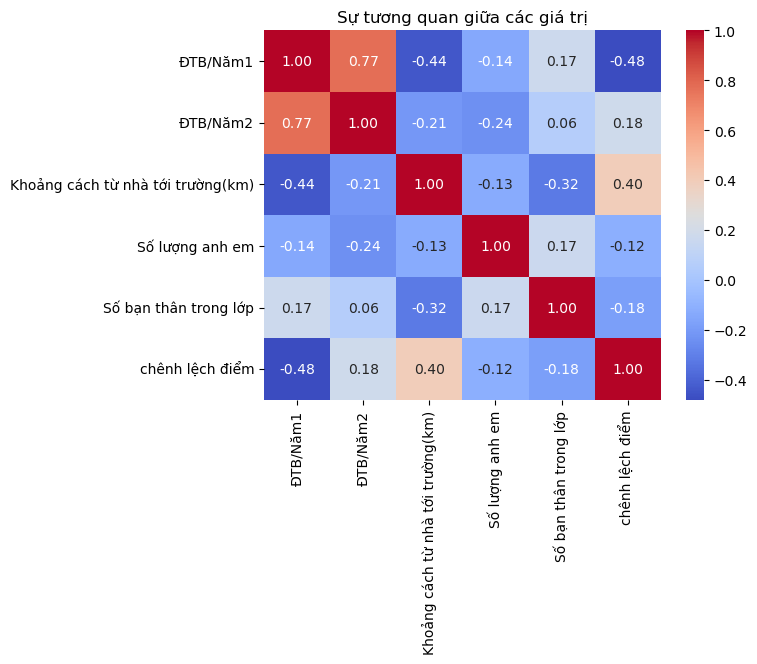

In [29]:
df_pd['chênh lệch điểm'] = (df_pd['ĐTB/Năm2'] - df_pd['ĐTB/Năm1'])
df_selected = df_pd[['ĐTB/Năm1','ĐTB/Năm2','Khoảng cách từ nhà tới trường(km)','Số lượng anh em','Số bạn thân trong lớp','chênh lệch điểm']]
corr = df_selected.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Sự tương quan giữa các giá trị")

    ĐTB/Năm1 và ĐTB/Năm2: Có một mối tương quan dương mạnh (0.77) giữa điểm trung bình năm thứ nhất và điểm trung bình năm thứ hai. Điều này ngụ ý rằng học sinh có xu hướng duy trì hoặc cải thiện điểm số của họ từ năm đầu tiên đến năm thứ hai.

    Khoảng cách từ nhà tới trường và ĐTB/Năm1: Có một tương quan tiêu cực (khoảng -0.44) giữa khoảng cách từ nhà tới trường và điểm trung bình năm thứ nhất. Điều này có thể ngụ ý rằng sinh viên có thể gặp khó khăn trong việc duy trì hiệu suất học tập khi phải di chuyển xa từ nhà tới trường.

    Số lượng anh em và Số bạn thân trong lớp: Có một mối tương quan đáng kể (0.50) giữa số lượng anh em và số bạn thân trong lớp. Điều này có thể ngụ ý rằng sinh viên có nhiều anh em có thể dễ dàng hòa đồng và có nhiều bạn trong lớp.

    Chênh lệch điểm và khoảng cách từ nhà tới trường: Có một tương quan đáng chú ý (0.40) giữa chênh lệch điểm và khoảng cách từ nhà tới trường. Có nghĩa là khi khoảng cách càng tăng thì chênh lệch giữa điểm trung bình năm 1 và năm 2 cũng tăng theo

<h2>ĐTB/Năm1 của từng sinh viên</h2>

In [30]:
# Layouts

# Chuyển đổi kiểu dữ liệu của cột 'ĐTB/Năm1'sang kiểu float
df = df.withColumn("ĐTB/Năm1", df["ĐTB/Năm1"].cast("float"))

# Chọn các cột 'MSSV', 'ĐTB/Năm1'
df1 = df.select('MSSV', 'ĐTB/Năm1').toPandas()
# Lấy hai số cuối của cột MSSV
df1['MSSV'] = df1['MSSV'].str[-3:]
# Output vào notebook
output_notebook()

# Khởi tạo các đối tượng figure cho từng subplot
fig1 = figure(width=300, height=300, title="ĐTB/Năm1 dưới 6")
fig2 = figure(width=300, height=300, title="ĐTB/Năm1 trên 6 và dưới 8")
fig3 = figure(width=300, height=300, title="ĐTB/Năm1 trên 8")

df_under_6= df1[df1['ĐTB/Năm1'] < 6]
fig1.circle(df_under_6['MSSV'], df_under_6['ĐTB/Năm1'], size=8, color='blue', alpha=0.5)

df_over_6_under_8 = df1[(df1['ĐTB/Năm1'] >= 6) & (df1['ĐTB/Năm1'] < 8)]
fig2.circle(df_over_6_under_8['MSSV'], df_over_6_under_8['ĐTB/Năm1'], size=8, color='green', alpha=0.5)

df_over_8= df1[df1['ĐTB/Năm1'] >= 8]
fig3.circle(df_over_8['MSSV'], df_over_8['ĐTB/Năm1'], size=8, color='red', alpha=0.5)

# Tạo một row layout
row_layout = row(fig1, fig2, fig3)
# Hiển thị biểu đồ
show(row_layout)


Loading BokehJS ...

<h2>ĐTB cả 2 năm của từng sinh viên</h2>

In [36]:


# Chọn các cột 'MSSV', 'ĐTB/Năm1'
df1 = df_pd[['MSSV', 'ĐTB/Năm1', 'ĐTB/Năm2', 'Khoảng cách từ nhà tới trường(km)']]
# Lấy hai số cuối của cột MSSV
# Output vào notebook
output_notebook()
df1['ĐTB'] = (df1['ĐTB/Năm1'] + df1['ĐTB/Năm2']) / 2
# Khởi tạo các đối tượng figure cho từng subplot
fig1 = figure(width=300, height=300, title="ĐTB cả 2 năm dưới 6")
fig2 = figure(width=300, height=300, title="ĐTB cả 2 năm trên 6 và dưới 8")
fig3 = figure(width=300, height=300, title="ĐTB cả 2 năm trên 8")

df_under_6= df1[df1['ĐTB'] < 6]
fig1.circle(df_under_6['Khoảng cách từ nhà tới trường(km)'], df_under_6['ĐTB'], size=8, color='blue', alpha=0.5)

df_over_6_under_8 = df1[(df1['ĐTB'] >= 6) & (df1['ĐTB'] < 8)]
fig2.circle(df_over_6_under_8['Khoảng cách từ nhà tới trường(km)'], df_over_6_under_8['ĐTB'], size=8, color='green', alpha=0.5)

df_over_8= df1[df1['ĐTB'] >= 8]
fig3.circle(df_over_8['Khoảng cách từ nhà tới trường(km)'], df_over_8['ĐTB'], size=8, color='red', alpha=0.5)

# Tạo một row layout
row_layout = row(fig1, fig2, fig3)
# Hiển thị biểu đồ
show(row_layout)


Loading BokehJS ...

/tmp/ipykernel_54/3462422900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ĐTB'] = (df1['ĐTB/Năm1'] + df1['ĐTB/Năm2']) / 2


In [34]:
# Hide click policy, Hovel tool, Tab panel


# Chọn các cột 'MSSV', 'ĐTB/Năm1', 'ĐTB/Năm2'
df1 = df_pd[['MSSV','Số bạn thân trong lớp', 'ĐTB/Năm1', 'ĐTB/Năm2']]
# Output vào notebook
output_notebook()

# Tạo đối tượng figure cho ĐTB/Năm1
fig1 = figure(width=600, height=400, title="Điểm Trung Bình theo số bạn thân trong lớp (Năm 1)",
           x_axis_label='Số bạn thân trong lớp', y_axis_label='ĐTB/Năm1')
# Lọc dữ liệu dưới 6
df_under_6_1 = df1[df1['ĐTB/Năm1'] < 6]
source_under_6_1 = ColumnDataSource(df_under_6_1)
fig1.circle('Số bạn thân trong lớp', 'ĐTB/Năm1', size=8, color='blue', alpha=0.5, legend_label='Dưới 6', source=source_under_6_1)
# Lọc dữ liệu trên 6 và dưới 8
df_over_6_under_8_1 = df1[(df1['ĐTB/Năm1'] >= 6) & (df1['ĐTB/Năm1'] < 8)]
source_over_6_under_8_1 = ColumnDataSource(df_over_6_under_8_1)
fig1.circle('Số bạn thân trong lớp', 'ĐTB/Năm1', size=8, color='green', alpha=0.5, legend_label='Trên 6 và Dưới 8', source=source_over_6_under_8_1)
# Lọc dữ liệu trên 8
df_over_8_1 = df1[df1['ĐTB/Năm1'] >= 8]
source_over_8_1 = ColumnDataSource(df_over_8_1)
fig1.circle('Số bạn thân trong lớp', 'ĐTB/Năm1', size=8, color='red', alpha=0.5, legend_label='Trên 8', source=source_over_8_1)
# Tạo hover tool và chỉ định thông tin khi di chuột qua cho ĐTB/Năm1
hover1 = HoverTool(tooltips=[('MSSV', '@MSSV'),
                             ('ĐTB/Năm1', '@{ĐTB/Năm1}'),
                            ('Số bạn thân trong lớp','@{Số bạn thân trong lớp}')],
                             mode='vline')
fig1.add_tools(hover1)
fig1.legend.click_policy = "hide"

# Tạo đối tượng figure cho ĐTB/Năm2
fig2 = figure(width=600, height=400, title="Điểm Trung Bình theo số bạn thân trong lớp (Năm 2)",
           x_axis_label='Số bạn thân trong lớp', y_axis_label='ĐTB/Năm2')
# Lọc dữ liệu dưới 6 cho ĐTB/Năm2
df1['ĐTB/Năm2'] = pd.to_numeric(df1['ĐTB/Năm2'], errors='coerce')
df_under_6_2 = df1[df1['ĐTB/Năm2'] < 6]
source_under_6_2 = ColumnDataSource(df_under_6_2)
fig2.circle('Số bạn thân trong lớp', 'ĐTB/Năm2', size=8, color='blue', alpha=0.5, legend_label='Dưới 6', source=source_under_6_2)
# Lọc dữ liệu trên 6 và dưới 8 cho ĐTB/Năm2
df_over_6_under_8_2 = df1[(df1['ĐTB/Năm2'] >= 6) & (df1['ĐTB/Năm2'] < 8)]
source_over_6_under_8_2 = ColumnDataSource(df_over_6_under_8_2)
fig2.circle('Số bạn thân trong lớp', 'ĐTB/Năm2', size=8, color='green', alpha=0.5, legend_label='Trên 6 và Dưới 8', source=source_over_6_under_8_2)
# Lọc dữ liệu trên 8 cho ĐTB/Năm2
df_over_8_2 = df1[df1['ĐTB/Năm2'] >= 8]
source_over_8_2 = ColumnDataSource(df_over_8_2)
fig2.circle('Số bạn thân trong lớp', 'ĐTB/Năm2', size=8, color='red', alpha=0.5, legend_label='Trên 8', source=source_over_8_2)
# Tạo hover tool và chỉ định thông tin khi di chuột qua cho ĐTB/Năm2
hover2 = HoverTool(tooltips=[('MSSV', '@MSSV'),
                             ('ĐTB/Năm2', '@{ĐTB/Năm2}'),
                            ('Số bạn thân trong lớp','@{Số bạn thân trong lớp}')],
                             mode='vline')
fig2.add_tools(hover2)
fig2.legend.click_policy = "hide"

# Tạo tab panel
tab1 = Panel(child=fig1, title="Năm 1")
tab2 = Panel(child=fig2, title="Năm 2")
tabs = Tabs(tabs=[tab1, tab2])

# Hiển thị biểu đồ
show(tabs)


Loading BokehJS ...

/tmp/ipykernel_54/3863355492.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ĐTB/Năm2'] = pd.to_numeric(df1['ĐTB/Năm2'], errors='coerce')
